In [30]:
import numpy as np
import pickle

In [31]:
orig_path = '/nas/Dataset/Phoenix/phoenix-2014-keypoints.pkl'
with open(orig_path, 'rb') as f:
    keypoints = pickle.load(f)

keypoints

{'fullFrame-210x260px/train/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute': {'keypoints': array([[[109.4   ,  48.53  ,   0.9727],
          [118.    ,  41.22  ,   0.9795],
          [ 99.06  ,  43.    ,   0.985 ],
          ...,
          [101.44  , 243.4   ,   0.828 ],
          [106.6   , 245.8   ,   0.8804],
          [110.1   , 246.6   ,   0.8843]],
  
         [[108.6   ,  47.16  ,   0.966 ],
          [117.9   ,  40.2   ,   0.9604],
          [ 98.7   ,  41.8   ,   0.9736],
          ...,
          [103.    , 239.6   ,   0.842 ],
          [106.8   , 241.5   ,   0.8643],
          [109.25  , 242.2   ,   0.848 ]],
  
         [[108.    ,  46.28  ,   0.9556],
          [117.56  ,  39.7   ,   0.9785],
          [ 98.06  ,  40.66  ,   0.9683],
          ...,
          [ 99.    , 227.6   ,   0.7515],
          [102.1   , 230.5   ,   0.813 ],
          [104.06  , 231.9   ,   0.8125]],
  
         ...,
  
         [[101.75  ,  65.1   ,   0.935 ],
          [110.2  

In [32]:
sample = keypoints['fullFrame-210x260px/train/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute']['keypoints']

sample.shape # (T, N, 3)

(176, 133, 3)

In [33]:
sample

array([[[109.4   ,  48.53  ,   0.9727],
        [118.    ,  41.22  ,   0.9795],
        [ 99.06  ,  43.    ,   0.985 ],
        ...,
        [101.44  , 243.4   ,   0.828 ],
        [106.6   , 245.8   ,   0.8804],
        [110.1   , 246.6   ,   0.8843]],

       [[108.6   ,  47.16  ,   0.966 ],
        [117.9   ,  40.2   ,   0.9604],
        [ 98.7   ,  41.8   ,   0.9736],
        ...,
        [103.    , 239.6   ,   0.842 ],
        [106.8   , 241.5   ,   0.8643],
        [109.25  , 242.2   ,   0.848 ]],

       [[108.    ,  46.28  ,   0.9556],
        [117.56  ,  39.7   ,   0.9785],
        [ 98.06  ,  40.66  ,   0.9683],
        ...,
        [ 99.    , 227.6   ,   0.7515],
        [102.1   , 230.5   ,   0.813 ],
        [104.06  , 231.9   ,   0.8125]],

       ...,

       [[101.75  ,  65.1   ,   0.935 ],
        [110.2   ,  51.34  ,   0.971 ],
        [ 89.9   ,  53.56  ,   0.959 ],
        ...,
        [ 11.14  , 170.    ,   0.8726],
        [ 13.586 , 174.    ,   0.909 ],
        [

In [ ]:
# Grid 크기 설정 (예: s=5)
s = 1

# (x, y) 좌표 분리
keypoints = sample[..., :2]  # (176, 133, 2)

# 첫 번째 프레임을 Grid 위에 정렬 (반올림)
first_frame = np.round(keypoints[0] / s) * s  # (133, 2)

# 변화량 (dx, dy) 계산
dx = np.diff(keypoints[..., 0], axis=0)  # x 변화량 (175, 133)
dy = np.diff(keypoints[..., 1], axis=0)  # y 변화량 (175, 133)

# 가능한 이동 벡터 정의 (9가지)
movement_vectors = np.array([
    (s, 0), (s, -s), (0, -s), (-s, -s), (-s, 0),
    (-s, s), (0, s), (s, s), (0, 0)
])

# 변화량을 9가지 값 중 가장 가까운 값으로 변환
quantized_dx = np.zeros_like(dx)
quantized_dy = np.zeros_like(dy)

for i in range(175):
    for j in range(133):
        diff = np.array([dx[i, j], dy[i, j]])  # 현재 변화량
        distances = np.linalg.norm(movement_vectors - diff, axis=1)  # 9가지 후보와 거리 계산
        best_match = movement_vectors[np.argmin(distances)]  # 가장 가까운 움직임 선택
        quantized_dx[i, j], quantized_dy[i, j] = best_match  # 저장

# 변환된 데이터 저장
transformed_data = np.zeros((176, 133, 2), dtype=np.float32)
transformed_data[0] = first_frame  # 첫 번째 프레임 (절대 좌표)
transformed_data[1:] = np.stack([quantized_dx, quantized_dy], axis=-1)  # 이후 프레임 (dx, dy)

# 변환된 데이터 확인
print("Grid size:", s)
print("Transformed shape:", transformed_data.shape)  # (176, 133, 2)
print("First frame (grid-aligned):", transformed_data[0, :5])  # 첫 프레임 좌표
print("Second frame (quantized movements):", transformed_data[1, :5])  # dx, dy 값 (9가지 중 하나)


Grid size: 10
Transformed shape: (176, 133, 2)
First frame (grid-aligned): [[110.  50.]
 [120.  40.]
 [100.  40.]
 [130.  50.]
 [ 90.  50.]]
Second frame (quantized movements): [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


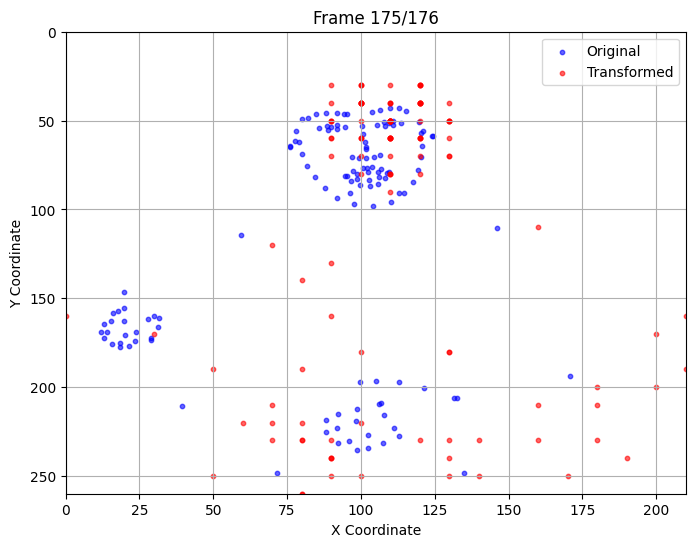

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 원본 데이터
original_x = sample[..., 0]  # (176, 133)
original_y = sample[..., 1]  # (176, 133)

# 변환된 데이터 복원 (첫 프레임 + 변화량 누적 합)
reconstructed_x = np.cumsum(transformed_data[..., 0], axis=0)  # 누적합 계산
reconstructed_y = np.cumsum(transformed_data[..., 1], axis=0)

# 애니메이션 설정
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 210)
ax.set_ylim(260, 0)  # OpenPose 좌표계는 (0,0)이 좌상단이므로 뒤집기
ax.set_title("Keypoint Comparison Over Time")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# 원본과 변환된 데이터를 시각화할 두 개의 scatter plot 생성
original_scatter = ax.scatter([], [], color='blue', label='Original', alpha=0.6, s=10)
transformed_scatter = ax.scatter([], [], color='red', label='Transformed', alpha=0.6, s=10)

ax.legend()
ax.grid(True)

# 업데이트 함수 정의 (애니메이션용)
def update(frame):
    original_scatter.set_offsets(np.column_stack((original_x[frame], original_y[frame])))
    transformed_scatter.set_offsets(np.column_stack((reconstructed_x[frame], reconstructed_y[frame])))
    ax.set_title(f"Frame {frame}/{original_x.shape[0]}")
    return original_scatter, transformed_scatter

# 애니메이션 생성
ani = animation.FuncAnimation(fig, update, frames=original_x.shape[0], interval=50, blit=True)
ani.save(f"keypoint_comparison_{s}.gif", writer="pillow", fps=20)


In [37]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# # 원본 데이터
# original_x = sample[..., 0]  # (176, 133)
# original_y = sample[..., 1]  # (176, 133)

# # 변화량(dx, dy) 계산 (그리드 없이 원본 변화량 그대로 사용)
# dx = np.diff(original_x, axis=0)  # (175, 133)
# dy = np.diff(original_y, axis=0)  # (175, 133)

# # 변화량 기반 데이터 재구성 (첫 번째 프레임 그대로 유지)
# transformed_data = np.zeros((sample.shape[0], sample.shape[1], 2))  # (176, 133, 2)
# transformed_data[0] = sample[0, :, :2]  # 첫 번째 프레임 유지 (x, y 좌표만)

# # 변화량을 이용한 나머지 프레임 채우기
# transformed_data[1:] = np.stack([dx, dy], axis=-1)  # (175, 133, 2) 변화량 저장

# # 변환된 데이터 복원 (누적합 사용)
# reconstructed_x = np.cumsum(transformed_data[..., 0], axis=0)
# reconstructed_y = np.cumsum(transformed_data[..., 1], axis=0)

# # 애니메이션 설정
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.set_xlim(0, 210)
# ax.set_ylim(260, 0)  # OpenPose 좌표계는 (0,0)이 좌상단이므로 뒤집기
# ax.set_title("Keypoint Comparison Over Time")
# ax.set_xlabel("X Coordinate")
# ax.set_ylabel("Y Coordinate")

# # 원본과 변환된 데이터를 시각화할 두 개의 scatter plot 생성
# # original_scatter = ax.scatter([], [], color='blue', label='Original', alpha=0.6, s=10)
# transformed_scatter = ax.scatter([], [], color='red', label='Transformed', alpha=0.6, s=10)

# ax.legend()
# ax.grid(True)

# # 업데이트 함수 정의 (애니메이션용)
# def update(frame):
#     original_scatter.set_offsets(np.column_stack((original_x[frame], original_y[frame])))
#     transformed_scatter.set_offsets(np.column_stack((reconstructed_x[frame], reconstructed_y[frame])))
#     ax.set_title(f"Frame {frame}/{original_x.shape[0]}")
#     return original_scatter, transformed_scatter

# # 애니메이션 생성
# ani = animation.FuncAnimation(fig, update, frames=original_x.shape[0], interval=50, blit=False)

# # 애니메이션 저장
# ani.save("keypoint_comparison_no_grid.gif", writer="pillow", fps=20)

/tmp/ipykernel_1579022/3743757261.py:13: RuntimeWarning: overflow encountered in divide
  first_frame = np.round(sample[0, :, :2] / s) * s  # (133, 2)


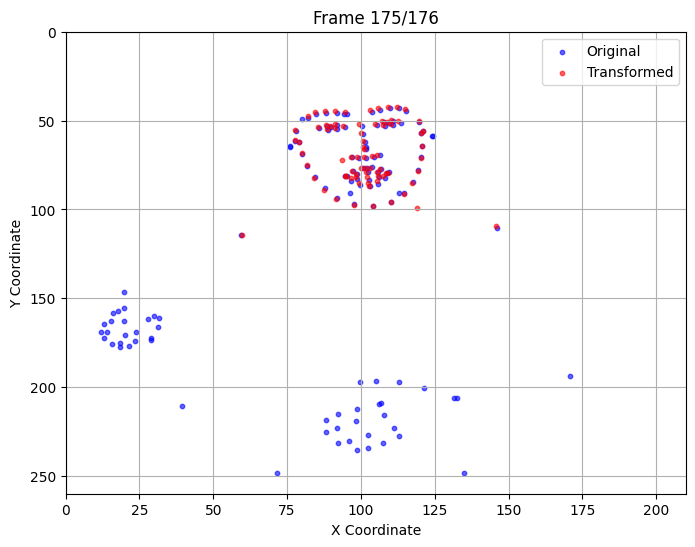

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 원본 데이터
original_x = sample[..., 0]  # (176, 133)
original_y = sample[..., 1]  # (176, 133)

# Grid 크기 설정 (예: s=5)
s = 1/400

# 🔹 첫 번째 프레임을 그리드 위에 정렬
first_frame = np.round(sample[0, :, :2] / s) * s  # (133, 2)

# 🔹 변화량 (dx, dy) 계산
dx = np.diff(original_x, axis=0)  # (175, 133)
dy = np.diff(original_y, axis=0)  # (175, 133)

# 🔹 가능한 이동 벡터 정의 (9가지 방향)
movement_vectors = np.array([
    (s, 0), (s, -s), (0, -s), (-s, -s), (-s, 0),
    (-s, s), (0, s), (s, s), (0, 0)
])

# 🔹 변화량을 9가지 벡터 중 하나로 변환 (큰 이동량을 작은 벡터로 분할)
quantized_dx = np.zeros_like(dx)
quantized_dy = np.zeros_like(dy)

for i in range(175):
    for j in range(133):
        remaining_dx = dx[i, j]
        remaining_dy = dy[i, j]
        
        # 🔹 큰 이동량을 여러 개의 작은 벡터로 분할
        while abs(remaining_dx) > s or abs(remaining_dy) > s:
            diff = np.array([remaining_dx, remaining_dy])
            distances = np.linalg.norm(movement_vectors - diff, axis=1)
            best_match = movement_vectors[np.argmin(distances)]
            
            # 저장된 변화량을 벡터 기반으로 갱신
            quantized_dx[i, j] += best_match[0]
            quantized_dy[i, j] += best_match[1]
            
            # 남은 이동량 업데이트
            remaining_dx -= best_match[0]
            remaining_dy -= best_match[1]
        
        # 마지막 남은 이동량을 가장 가까운 벡터로 변환
        diff = np.array([remaining_dx, remaining_dy])
        distances = np.linalg.norm(movement_vectors - diff, axis=1)
        best_match = movement_vectors[np.argmin(distances)]
        quantized_dx[i, j] += best_match[0]
        quantized_dy[i, j] += best_match[1]

# 🔹 변환된 데이터 저장 (오직 9가지 벡터만 사용)
transformed_data = np.zeros((176, 133, 2), dtype=np.float32)
transformed_data[0] = first_frame  # 첫 번째 프레임 (절대 좌표)
transformed_data[1:] = np.stack([quantized_dx, quantized_dy], axis=-1)  # 이후 프레임 (dx, dy)

# 🔹 변환된 데이터 복원 (오직 9가지 벡터를 사용하여 재구성)
for t in range(1, 176):
    transformed_data[t, :, 0] = transformed_data[t - 1, :, 0] + quantized_dx[t - 1]
    transformed_data[t, :, 1] = transformed_data[t - 1, :, 1] + quantized_dy[t - 1]

reconstructed_x = transformed_data[..., 0]
reconstructed_y = transformed_data[..., 1]

# 🔹 애니메이션 설정
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 210)
ax.set_ylim(260, 0)  # OpenPose 좌표계는 (0,0)이 좌상단이므로 뒤집기
ax.set_title("Keypoint Comparison Over Time (9-Vector with Split Large Motion)")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

# 원본과 변환된 데이터를 시각화할 두 개의 scatter plot 생성
original_scatter = ax.scatter([], [], color='blue', label='Original', alpha=0.6, s=10)
transformed_scatter = ax.scatter([], [], color='red', label='Transformed', alpha=0.6, s=10)

ax.legend()
ax.grid(True)

# 🔹 업데이트 함수 정의 (애니메이션용)
def update(frame):
    original_scatter.set_offsets(np.column_stack((original_x[frame], original_y[frame])))
    transformed_scatter.set_offsets(np.column_stack((reconstructed_x[frame], reconstructed_y[frame])))
    ax.set_title(f"Frame {frame}/{original_x.shape[0]}")
    return original_scatter, transformed_scatter

# 🔹 애니메이션 생성
ani = animation.FuncAnimation(fig, update, frames=original_x.shape[0], interval=50, blit=False)

# 🔹 애니메이션 저장
ani.save("keypoint_comparison_9vectors_split.gif", writer="pillow", fps=20)
plt.show()


In [39]:
quantized_dx[0]

array([-0.7354, -0.125 , -0.3691, -0.3691, -0.2471, -0.7354,  0.2471,
       -0.3691, -0.3984,  0.2471, -2.83  , -1.122 ,  0.7354,  8.    ,
        0.7354, -3.22  ,  2.098 , -8.    , -8.    ,  8.    ,  2.39  ,
        2.342 , -1.342 , -0.186 , -0.3691, -0.4912, -0.6133, -0.7354,
       -0.6133, -0.6133, -0.6133, -0.6743, -0.7354, -0.6743, -0.5522,
       -0.4912, -0.3691, -0.3691, -0.2471, -0.2471, -0.308 , -0.308 ,
       -0.308 , -0.308 , -0.308 , -0.186 , -0.0625,  0.0625,  0.125 ,
        0.125 , -0.4302, -0.4912, -0.6743, -0.7964, -0.6743, -0.7354,
       -0.7354, -0.7964, -0.7964, -0.3691, -0.3691, -0.3691, -0.3691,
       -0.3691, -0.4302, -0.308 , -0.186 , -0.0625,  0.    , -0.125 ,
       -0.186 , -0.7354, -0.7354, -0.7354, -0.7964, -0.8574, -0.9185,
       -0.9185, -1.195 , -1.195 , -1.122 , -0.9185, -0.7354, -0.7354,
       -0.7354, -0.8574, -0.9185, -0.9795, -1.049 , -1.049 , -0.7964,
        0.2471,  0.7354,  1.122 ,  2.195 ,  2.684 , -0.6133, -0.7354,
        0.7354,  2.0

In [40]:
transformed_data[0][15], transformed_data[1][15]

(array([129.25,    inf], dtype=float32),
 array([126.0293,      inf], dtype=float32))

In [41]:
quantized_dy[0]

array([-1.415 , -1.014 , -1.195 ,  0.645 ,  0.    , -0.4302,  0.186 ,
       -0.4912, -0.6133, -2.781 , -2.977 , -2.    , -1.8545, -8.    ,
       -0.8574, -8.    , -1.781 , -8.    , -8.    , -8.    , -8.    ,
       -8.    , -8.    ,  0.0625, -0.125 , -0.2764, -0.3984, -0.5522,
       -0.7964, -0.9795, -1.269 , -1.269 , -1.195 , -0.8574, -0.4302,
       -0.0625,  0.125 ,  0.3691,  0.4595,  0.3374, -0.6743, -0.645 ,
       -0.7354, -0.828 , -0.9185, -0.9795, -0.95  , -0.904 , -0.767 ,
       -0.584 , -1.269 , -1.38  , -1.453 , -1.38  , -1.415 , -1.38  ,
       -1.269 , -1.195 , -1.122 , -1.122 , -1.122 , -1.195 , -1.269 ,
       -1.269 , -1.233 , -1.195 , -1.087 , -0.95  , -0.828 , -0.9795,
       -1.122 , -1.6   , -1.453 , -1.233 , -1.195 , -1.16  , -1.16  ,
       -1.233 , -1.819 , -2.293 , -2.537 , -2.39  , -2.074 , -1.635 ,
       -1.562 , -1.415 , -1.342 , -1.307 , -1.819 , -2.146 , -2.049 ,
       -2.781 , -3.074 , -3.953 , -3.855 , -3.953 , -7.227 , -8.    ,
       -8.    , -8. 

In [42]:
import pickle

with open('/nas/Dataset/Phoenix/phoenix-2014-doppler-vectorized.pkl', 'rb') as f:
    dd = pickle.load(f)

dd

{'fullFrame-210x260px/train/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute': {'keypoints': array([[[-1,  0,  0],
          [-1,  0,  0],
          [-1,  0,  0],
          ...,
          [-1,  0,  0],
          [-1,  0,  0],
          [-1,  0,  0]],
  
         [[-1,  0,  0],
          [-1,  0,  0],
          [-1,  0,  0],
          ...,
          [ 0,  0,  0],
          [-1,  0,  0],
          [-1,  0,  0]],
  
         [[-1,  0,  0],
          [-1,  0,  0],
          [-1,  0,  0],
          ...,
          [-1, -1,  0],
          [-1,  0,  0],
          [-1,  0,  0]],
  
         ...,
  
         [[-1,  1,  0],
          [-1,  1,  0],
          [-1,  0,  0],
          ...,
          [ 0,  1,  0],
          [ 0,  1,  0],
          [ 0,  1,  0]],
  
         [[-1,  0,  0],
          [-1,  1,  0],
          [-1,  0,  0],
          ...,
          [ 0,  1,  0],
          [ 0,  1,  0],
          [ 0,  1,  0]],
  
         [[-1,  0,  0],
          [-1,  0,  0],
          

In [43]:
sample = dd['fullFrame-210x260px/train/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute']['keypoints']

sample

array([[[-1,  0,  0],
        [-1,  0,  0],
        [-1,  0,  0],
        ...,
        [-1,  0,  0],
        [-1,  0,  0],
        [-1,  0,  0]],

       [[-1,  0,  0],
        [-1,  0,  0],
        [-1,  0,  0],
        ...,
        [ 0,  0,  0],
        [-1,  0,  0],
        [-1,  0,  0]],

       [[-1,  0,  0],
        [-1,  0,  0],
        [-1,  0,  0],
        ...,
        [-1, -1,  0],
        [-1,  0,  0],
        [-1,  0,  0]],

       ...,

       [[-1,  1,  0],
        [-1,  1,  0],
        [-1,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0]],

       [[-1,  0,  0],
        [-1,  1,  0],
        [-1,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0]],

       [[-1,  0,  0],
        [-1,  0,  0],
        [-1,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  0,  0]]], dtype=int8)

In [44]:
sample.shape

(176, 133, 3)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# sample 데이터는 (176, 133, 3) shape를 가정합니다.
# sample의 각 프레임에서 [:, :, :2]는 x, y의 변화량을 나타냅니다.
# 초기 위치를 (100, 100)으로 설정하고 누적합을 이용해 실제 좌표를 구합니다.
initial_offset = np.array([100, 100])
positions = np.cumsum(sample[:, :, :2], axis=0) + initial_offset
# positions의 shape: (176, 133, 2)

# 애니메이션을 위한 figure와 축 설정
fig, ax = plt.subplots()
scat = ax.scatter(positions[0, :, 0], positions[0, :, 1], c='blue')

# 좌표의 범위를 데이터에 맞게 설정 (여유 공간 10 추가)
ax.set_xlim(np.min(positions[:, :, 0]) - 10, np.max(positions[:, :, 0]) + 10)
ax.set_ylim(np.min(positions[:, :, 1]) - 10, np.max(positions[:, :, 1]) + 10)
ax.set_title('Keypoints Animation')

# 각 프레임마다 scatter plot의 위치를 업데이트하는 함수
def update(frame):
    scat.set_offsets(positions[frame])
    ax.set_title(f'Frame {frame}')
    return scat,

# FuncAnimation을 사용하여 애니메이션 생성
ani = animation.FuncAnimation(
    fig, update, frames=positions.shape[0], interval=100, blit=True
)

# 애니메이션을 GIF 파일로 저장 (Pillow writer 사용, fps는 10)
ani.save('animation.gif', writer='pillow', fps=10)

# GIF 파일 저장 후 figure를 닫아줍니다.
plt.close()

